In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

import dataclasses

# Decaying Turbulence

In [2]:
%%time 

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.NavierStokes2D(viscosity, grid, smooth=smooth), dt)

# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 2.41 s, sys: 84.3 ms, total: 2.5 s
Wall time: 2.03 s


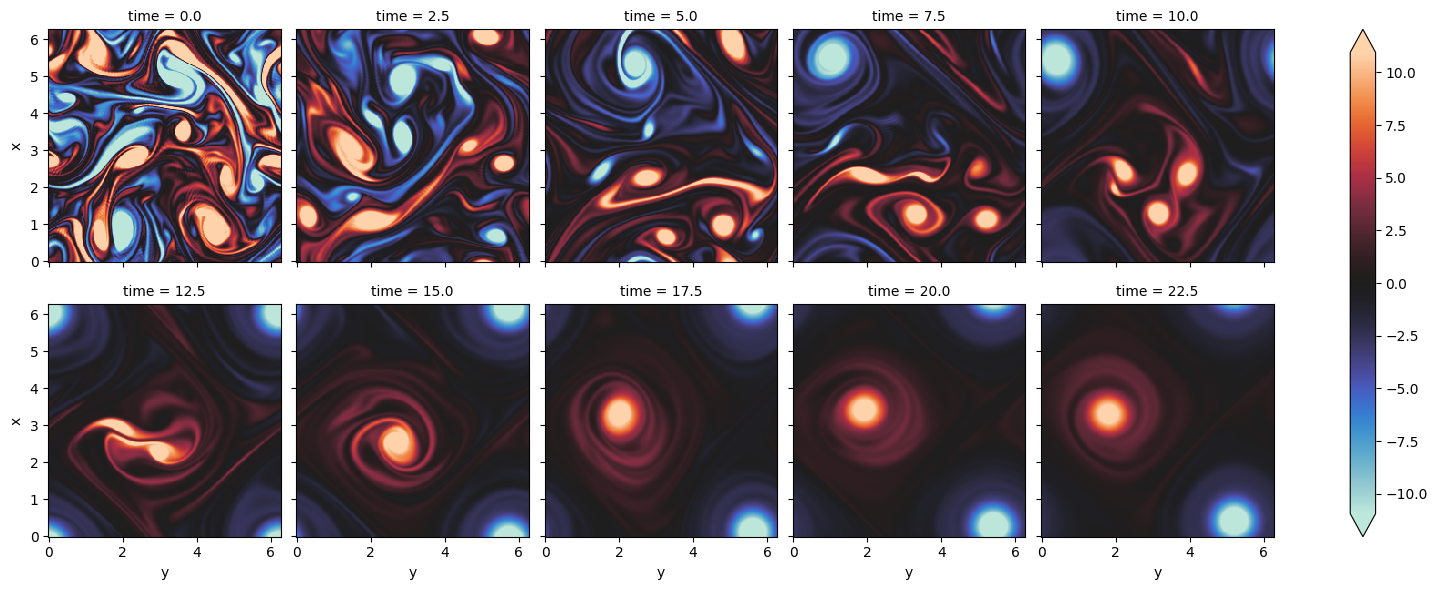

In [3]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

# Forced Turbulence

Same as unforced turbulence (above) except it uses default settings defined in `spectral.equations.ForcedNavierStokes2D`.

In [4]:
%%time 

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 


# **use predefined settings for Kolmogorov flow**
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt)


# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 928 ms, sys: 34.3 ms, total: 962 ms
Wall time: 386 ms


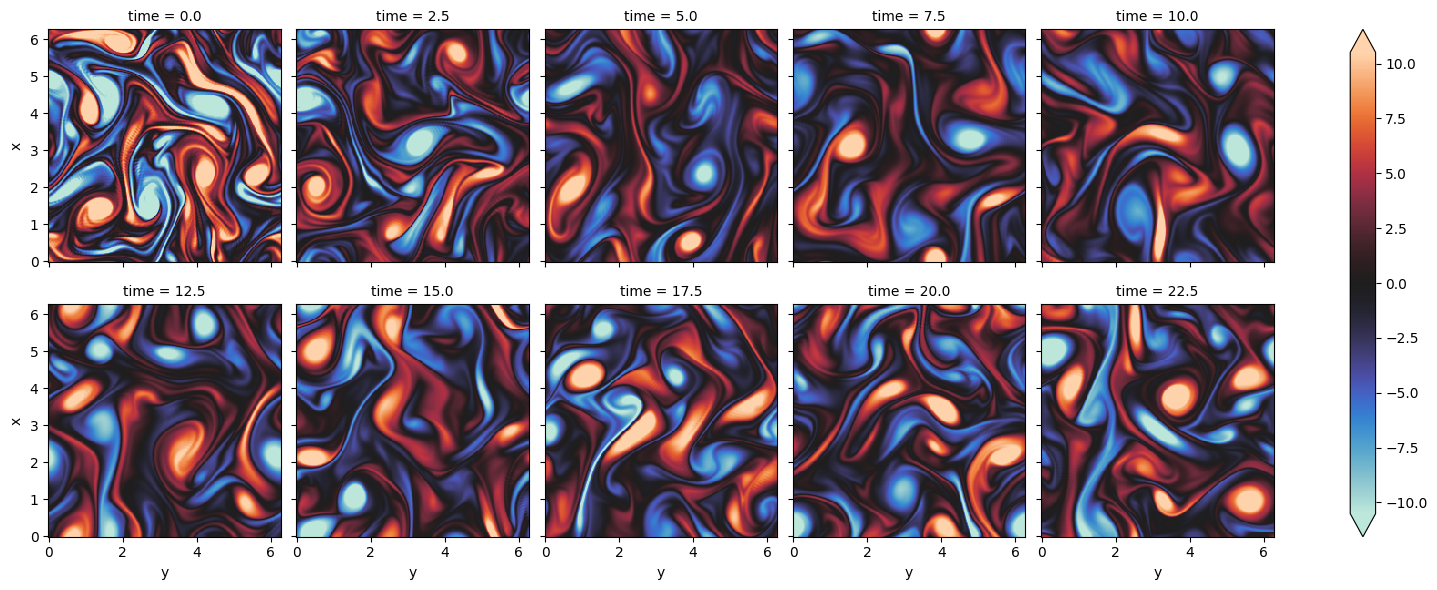

In [5]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

(10, 256, 129)